# Evaluate 

In [1]:
import sys
print(sys.executable, sys.version)


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import trimesh

from os.path import join, abspath
from IPython.display import display, HTML
from glob import glob

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

%matplotlib inline

# for local import 
sys.path.append(abspath('..'))

from main.config import Config
from main.model import Model
from main.dataset import Dataset
from main.smpl import Smpl

from vis_util import draw_2d_on_image, show_2d_pose, show_3d_pose

/home/mmc-user/.virtualenvs/hmr2-notebook/bin/python3 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


In [2]:
# eval_date = '02052020-143216'
# eval_date = '04052020-181359'
# eval_date = '08052020-102709' # 3d with regenerated H36M 
eval_date = '22052020-165507' # 3d with total capture and regenerated H36M 
# eval_date = '25052020-171905' # total capture and regenerated H36M but w/ 3D groundtruth
# eval_date = '19072020-155302' # 3d with toes regressor
# eval_date = '26072020-191649' # with toes regressor but w/ 3D groundtruth
# eval_date = '05082020-170502' # 3d with toes regressor w/ total cap
# eval_date = '01082020-085108' # with toes regressor but w/ 3D groundtruth w/ total cap


class EvalConfig(Config):
    BATCH_SIZE = 64
    ENCODER_ONLY = True
    LOG_DIR = join('/', 'data', 'ssd1', 'russales', 'logs', eval_date)
    DATA_DIR = join('/', 'data', 'ssd1', 'russales', 'tfrecords_with_toes')
    DATASETS = ['mpii_3d', 'h36m', 'total_cap']
    JOINT_TYPE = 'cocoplus'
    # JOINT_TYPE = 'custom'
    # RESTORE_PATH = join(LOG_DIR, 'ckpt-6')

# class Config is implemented as singleton, inizialize subclass first!
config = EvalConfig()

In [3]:
# inizialize model 
model = Model()

Saving logs to /data/ssd1/russales/logs/22052020-165507

Configurations:
BATCH_SIZE                     64
CUSTOM_REGRESSOR_IDX           {0: 'regressor_toes_right.npy', 7: 'regressor_toes_left.npy'}
CUSTOM_REGRESSOR_PATH          /home/mmc-user/workspace/hmr2.0/models/regressors
DATASETS                       ['mpii_3d', 'h36m', 'total_cap']
DATA_DIR                       /data/ssd1/russales/tfrecords_with_toes
DISCRIMINATOR_LEARNING_RATE    0.0001
DISCRIMINATOR_LOSS_WEIGHT      1
DISCRIMINATOR_WEIGHT_DECAY     0.0001
DS_KP2D                        {'lsp': 14, 'cocoplus': 19, 'custom': 21}
DS_KP3D                        {'lsp': 14, 'cocoplus': 14, 'custom': 16}
ENCODER_INPUT_SHAPE            (224, 224, 3)
ENCODER_ONLY                   True
EPOCHS                         55
GENERATOR_2D_LOSS_WEIGHT       60.0
GENERATOR_3D_LOSS_WEIGHT       60.0
GENERATOR_LEARNING_RATE        1e-05
GENERATOR_WEIGHT_DECAY         0.0001
INITIALIZE_CUSTOM_REGRESSOR    False
ITERATIONS                    

### run evaluation

In [5]:
return_kps = True
result = model.test(return_kps=return_kps)

initialize test dataset...
Done (t=0.29073524475097656)

Start of Testing



Time taken for testing 238.98161125183105 sec



### sort results by sequence 

In [6]:
all_kp3d_mpjpe = result['kp3d_mpjpe'].numpy()
all_kp3d_mpjpe_aligned = result['kp3d_mpjpe_aligned'].numpy()
sequences = result['seq'].numpy()
if return_kps:    
    kps3d_real = result['kps3d_real'].numpy()
    kps3d_pred = result['kps3d_pred'].numpy()

### evaluate per sequence 

In [7]:
eval_dict = {}
indices = range(len(sequences))
for i, sequence in zip(indices, sequences):
    sequence = sequence.decode("utf-8")
    # ignore camera 2 and 3 for mpii 3d
    if ' 2_' in sequence or ' 3_' in sequence:
        continue
    mpjpe_tuple = tuple([all_kp3d_mpjpe[i], all_kp3d_mpjpe_aligned[i]])
    if sequence not in eval_dict:
        eval_dict[sequence] = [mpjpe_tuple]
    else:
        eval_dict[sequence].append(mpjpe_tuple)

In [8]:
names, data = eval_dict.keys(), np.ndarray(shape=(len(eval_dict), 9), dtype=np.float32)

indices = range(len(names))
for i, value in zip(indices, eval_dict.values()):
    values_per_seq = np.asarray(value, dtype=np.float32)
    mpjpe = values_per_seq[:, 0, :]
    mpjpe_aligned = values_per_seq[:, 1, :]
    
    mean_mpjpe_aligned = np.mean(mpjpe_aligned)
    mean_mpjpe = np.mean(mpjpe)
    
    data[i, 0] = mean_mpjpe_aligned  # mean_error_aligned
    data[i, 1] = mean_mpjpe  # mean_error
    data[i, 2] = np.median(mpjpe)  # median_error
    data[i, 3] = np.std(mpjpe)  # standard deviation
    data[i, 4] = mpjpe.min()  # min
    data[i, 5] = mpjpe.max()  # max
    data[i, 6] = np.percentile(mpjpe, 25)  # 25 percentile
    data[i, 7] = np.percentile(mpjpe, 50)  # 50 percentile
    data[i, 8] = np.percentile(mpjpe, 75)  # 75 percentile
        
columns = ['Mean Aligned', 'Mean', 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']
df_seq = pd.DataFrame(data, index=names, columns=columns)

df_seq = df_seq.sort_values(df_seq.columns[0]) # sort by ascending mean aligned

display(HTML(df_seq.to_html()))

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
h36m_sub11_Discussion 1_cam54138969,52.772774,85.515526,70.957603,61.317268,3.355002,400.107605,39.308861,70.957603,119.753723
h36m_sub11_Posing_cam54138969,53.848331,89.162117,75.126984,60.962013,7.031653,474.347351,45.905762,75.126984,117.059616
h36m_sub11_Posing 1_cam54138969,54.887211,82.191811,72.792412,50.521744,2.888747,372.772675,44.815331,72.792412,105.967445
h36m_sub11_Purchases_cam54138969,55.300835,83.146820,72.460106,56.626080,6.689694,539.664062,41.759819,72.460106,112.634392
h36m_sub11_Posing 1_cam58860488,56.844261,110.399330,95.311783,68.593971,9.143811,366.795319,58.598953,95.311783,148.834091
h36m_sub11_Purchases 1_cam54138969,56.945881,89.138519,77.029060,60.309113,5.257767,667.449219,46.073689,77.029060,121.445099
h36m_sub11_Discussion 1_cam58860488,58.392342,102.103981,86.413879,69.089249,0.946903,444.074188,51.063389,86.413879,135.438721
h36m_sub11_Posing_cam58860488,58.495872,112.684708,96.111450,69.445412,14.230399,397.204224,59.008366,96.111450,152.045837
h36m_sub11_Posing 1_cam55011271,59.270798,123.134109,86.276146,143.663727,4.541719,1404.608521,52.031609,86.276146,139.417450
h36m_sub11_Directions 1_cam54138969,59.397648,89.755501,68.817848,70.338882,3.159295,535.868103,39.382622,68.817848,122.506317


In [9]:
df_seq.describe()

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,82.388535,133.234406,110.317711,98.026741,5.144750,976.530762,68.607018,110.317711,168.809341
std,15.782651,32.496922,28.326708,29.234163,2.511759,311.433258,18.225019,28.326708,41.455849
min,52.772774,82.191811,65.655090,50.521744,0.618808,366.795319,37.034409,65.655090,105.511879
25%,71.407318,109.796595,89.084879,77.398972,3.381760,739.531036,55.024939,89.084879,139.377041
50%,79.288162,126.589951,103.837574,92.317574,4.845758,932.989227,65.030006,103.837574,159.354599
75%,91.441418,150.882050,125.599531,111.172930,6.380345,1222.932556,77.933336,125.599531,189.796864
max,141.600143,266.177612,212.239014,239.488068,15.965500,1680.763916,135.437729,212.239014,342.086121


### evaluate per joint

In [10]:
eval_joint_dict = {
    'h36m': [],
    # 'mpii_3d': [],
    'TC': []
}

indices = range(len(sequences))
for i, sequence in zip(indices, sequences):
    sequence = sequence.decode("utf-8")
    if ' 2_' in sequence or ' 3_' in sequence:
        continue
    mpjpe_tuple = tuple([all_kp3d_mpjpe_aligned[i], all_kp3d_mpjpe[i]])
    key = [k for k in eval_joint_dict.keys() if k in sequence][0]
    eval_joint_dict[key].append(mpjpe_tuple)

In [11]:
joint_type = config.JOINT_TYPE
config.JOINT_TYPE = 'custom'
columns = ['Mean Aligned', 'Mean'] #, 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']
lsp_joints = ['ankle_r', 'knee_r', 'hip_r', 'hip_l', 'knee_l', 
             'ankle_l', 'wrist_r', 'elbow_r', 'shoulder_r', 
             'shoulder_l', 'elbow_l', 'wrist_l', 'neck', 'brain']


custom_joints = ['toes_r', 'ankle_r', 'knee_r', 'hip_r', 'hip_l', 'knee_l', 
             'ankle_l', 'toes_l', 'wrist_r', 'elbow_r', 'shoulder_r', 
             'shoulder_l', 'elbow_l', 'wrist_l', 'neck', 'brain']

joints = custom_joints if config.JOINT_TYPE == 'custom' else lsp_joints
num_joints = 16 if config.JOINT_TYPE == 'custom' else 14

df_frames = []
for key, value in eval_joint_dict.items(): 
    ds_mpjpe_aligned = np.asarray(value)[:, 0, :]
    ds_mpjpe = np.asarray(value)[:, 1, :]
    
    data = np.ndarray(shape=(num_joints, len(columns)), dtype=float)
    for i, _ in enumerate(joints):
        data[i, 0] = np.mean(ds_mpjpe_aligned[:, i])  # mean_error_aligned
        data[i, 1] = np.mean(ds_mpjpe[:, i])  # mean_error
        # data[i, 2] = np.median(ds_mpjpe[:, i])  # median_error
        # data[i, 3] = np.std(ds_mpjpe[:, i])  # standard deviation
        # data[i, 4] = ds_mpjpe[:, i].min()  # min
        # data[i, 5] = ds_mpjpe[:, i].max()  # max
        # data[i, 6] = np.percentile(ds_mpjpe[:, i], 25)  # 25 percentile
        # data[i, 7] = np.percentile(ds_mpjpe[:, i], 50)  # 50 percentile
        # data[i, 8] = np.percentile(ds_mpjpe[:, i], 75)  # 75 percentile
    
    df = pd.DataFrame(data, index=joints, columns=columns)
    df = df.sort_values(df.columns[0])
    df_frames.append(df)

df_joint = pd.concat(df_frames, axis=1, sort=False, keys=list(eval_joint_dict.keys()))
display(HTML(df_joint.to_html()))

# set back joint type 
config.JOINT_TYPE = joint_type

### evaluate overall

In [12]:
all_mpjpe_aligned = np.mean(all_kp3d_mpjpe_aligned)
all_mpjpe = np.mean(all_kp3d_mpjpe)

print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(all_mpjpe_aligned, all_mpjpe))

Mean Aligned: 82.968 --- Mean: 133.918


In [13]:
percentiles = [10, 30, 50, 70, 90]
data = np.ndarray(shape=(5, 2), dtype=float)
for i, percentile in enumerate(percentiles):
    data[i, 0] = np.percentile(all_kp3d_mpjpe_aligned, percentile)
    data[i, 1] = np.percentile(all_kp3d_mpjpe, percentile)

columns = ['10%', '30%', '50%', '70%', '90%']
df_percentiles = pd.DataFrame(data.T, index=['Mean Aligned', 'Mean'], columns=columns)
df_percentiles

,10%,30%,50%,70%,90%
Mean Aligned,28.215578,48.029537,67.996235,94.782426,153.061543
Mean,39.156012,73.279235,108.199528,154.874625,250.883572


In [14]:
def eval_per_dataset(name):
    len_ds = len([k for k in eval_dict.keys() if name in k])
    data = []

    indices = range(len(eval_dict.keys()))
    for i, (key, value) in zip(indices, eval_dict.items()):
        if name not in key:
            continue

        values_per_seq = np.asarray(value, dtype=np.float32)
        mpjpe = values_per_seq[:, 0, :]
        mpjpe_aligned = values_per_seq[:, 1, :]

        mean_mpjpe_aligned = np.mean(mpjpe_aligned)
        mean_mpjpe = np.mean(mpjpe)
        
        data.append(tuple([mean_mpjpe_aligned, mean_mpjpe]))  
        
    if len(data) == 0:
        return 0, 0
    
    data = np.asarray(data, dtype=float)
    return np.mean(data[:, 0]), np.mean(data[:, 1])

In [15]:
mpjpe_aligned_mpi, mpjpe_mpi = eval_per_dataset('h36m')
print('HUMAN 3.6M')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_mpi, mpjpe_mpi))

HUMAN 3.6M
Mean Aligned: 77.348 --- Mean: 119.098


In [16]:
mpjpe_aligned_mpi, mpjpe_mpi = eval_per_dataset('mpi')
print('MPII 3D')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_mpi, mpjpe_mpi))

MPII 3D
Mean Aligned: 0.000 --- Mean: 0.000


In [17]:
mpjpe_aligned_tc, mpjpe_tc = eval_per_dataset('TC')
print('Total Capture')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_tc, mpjpe_tc))

Total Capture
Mean Aligned: 91.462 --- Mean: 158.681


### save to csv

In [18]:
dataframes = pd.concat([df_seq, df_joint], axis=1)
dataframes.to_csv('evaluation_{}.csv'.format(eval_date))

### Visualize

### run inference and visualize

In [28]:
example = join("/data/ssd1/russales/tfrecords/lsp", "002_val.tfrecord")
# example = join("/data/ssd1/russales/tfrecords_with_toes/total_cap", "305_test.tfrecord")

# load record
dataset = Dataset()
dataset = dataset.get_data_for(example).shuffle(500, seed=14)

In [131]:
# run inference
for example in dataset.take(1):
    original = example
    result = model.detect(example[0])

#### show original image with ground truth

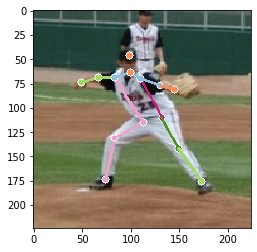

In [132]:
%matplotlib inline
image = original[0].numpy()
kp2d = original[1].numpy()[:, :2]
vis = original[1].numpy()[:, 2]

image = draw_2d_on_image(image, kp2d, vis=vis)
plt.imshow(image)
plt.show()

#### show image with predicted 2d keypoints

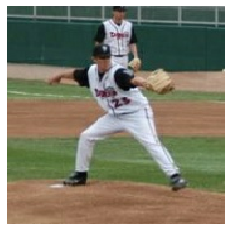

In [133]:
image = original[0].numpy()
#kp2d = np.squeeze(result['kp2d'].numpy())
#vis = original[1].numpy()[:, 2]
#image = draw_2d_on_image(image, kp2d, vis=vis)
image = ((image + 1) / 2 * 255).astype(np.uint8)
plt.axis('off')
plt.imshow(image)
plt.show()

#### show both poses in seperate plots 

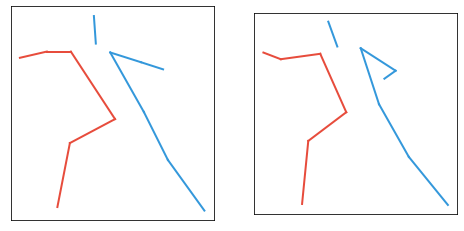

In [134]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

vis = np.expand_dims(original[1].numpy()[:, 2], -1)

kp2d_real = original[1].numpy() * vis
show_2d_pose(kp2d_real, vis, ax1)

kp2d_pred = result['kp2d'].numpy() * vis
show_2d_pose(kp2d_pred, vis, ax2)

<IPython.core.display.Javascript object>


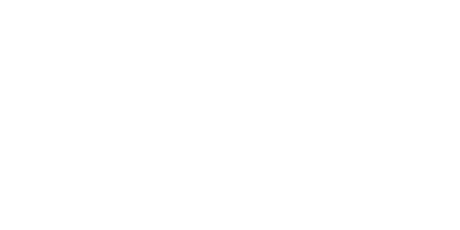

<IPython.core.display.Javascript object>


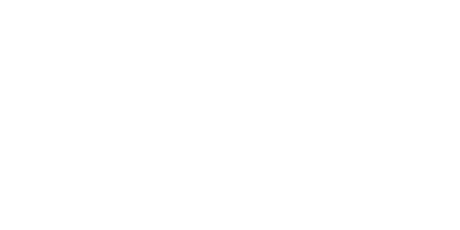

In [135]:
%matplotlib notebook
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# only use predicted camera
camera = np.squeeze(result['cam'].numpy())

# Plot 3d gt
kp3d_real = original[2].numpy()
show_3d_pose(kp3d_real, ax1)

# Plot 3d predictions
kp3d_pred = np.squeeze(result['kp3d'].numpy())
kp3d_pred = kp3d_pred[:config.NUM_KP3D, :] # only lsp prediction
show_3d_pose(kp3d_pred, ax2)

In [136]:
image = original[0].numpy()

vertices = np.squeeze(result['vertices'].numpy())

In [137]:
from trimesh_renderer import TrimeshRenderer
renderer = TrimeshRenderer()

mesh = renderer.mesh(vertices)
mesh.show()

### check for angles 

In [27]:
eval_angle_dict = {
    'h36m': [],
    # 'mpii_3d': [],
    'TC': []
}

indices = range(len(sequences))
for i, sequence in zip(indices, sequences):
    sequence = sequence.decode("utf-8")
    if ' 2_' in sequence or ' 3_' in sequence:
        continue
        
    kps3d = tuple([kps3d_pred[i], kps3d_real[i]])
    key = [k for k in eval_angle_dict.keys() if k in sequence][0]
    eval_angle_dict[key].append(kps3d)

In [28]:
def calc_angle(a, b, c):
    a = np.squeeze(a)
    b = np.squeeze(b)
    c = np.squeeze(c)
    ba = a - b
    bc = c - b

    dot = np.dot(ba, bc)
    cosine_angle =  dot / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    degree = np.degrees(angle)
    return degree

In [29]:
angles_indices = {
    'angles_r': [0, 1, 2],
    'angles_l': [7, 6, 5]
}
keypoints = {'pred': 0, 'real': 1}

def check_angles(angle_type, index):
    result = {}
    for key, kp3d in eval_angle_dict.items(): 
        kp3d = np.asarray(kp3d, dtype=np.float32)
        kp3d = kp3d[:, index, :]
        
        angles = angles_indices[angle_type]
        data = []
        for kp in kp3d:
            data.append(calc_angle(kp[angles[0]], kp[angles[1]], kp[angles[2]]))
        
        data = np.nan_to_num(data)
        new_data = []
        new_data.append(data[np.where(data < np.percentile(data, 15))[0]])
        new_data.append(data[np.where(data > np.percentile(data, 85))[0]])
        new_data = np.concatenate(new_data, -1)
        data = np.nan_to_num(new_data)
        print(data)
        
        print("done:", key)
        mean = np.mean(data)
        median = np.median(data)
        std = np.std(data)  
        min_ = data.min() 
        max_ = data.max()
        perc_25 = np.percentile(data, 25)  
        perc_50 = np.percentile(data, 50)  
        perc_75 = np.percentile(data, 75) 

        result[key] = [mean, median, std, min_, max_, perc_25, perc_50, perc_75]        

    return result 

In [30]:
data_angles = []
for keypoint, index in keypoints.items():    
    for angle in angles_indices.keys():
        print('start checking ', keypoint, angle)
        data_angles.append(check_angles(angle, index))

start checking  pred angles_r
[ 66.34182  74.67732  66.27073 ...  97.71077 102.73374  94.39826]
done: h36m
[ 72.366714  66.46421   69.80018  ... 108.31331  122.514435 122.85796 ]
done: TC
start checking  pred angles_l
[ 78.99067   79.125656  79.13864  ... 112.03837  101.70919  111.58804 ]
done: h36m
[ 76.735725  68.78835   69.30408  ... 104.995766 104.379005 101.16763 ]
done: TC
start checking  real angles_r
[ 76.6721   76.0911   75.8978  ...  95.27417 100.67158  95.45924]
done: h36m
[ 82.227974  82.876495  82.332115 ... 110.73083  101.94064  103.229065]
done: TC
start checking  real angles_l
[67.55036 70.45755 66.00718 ... 96.04975 88.22321 98.96425]
done: h36m
[ 80.33742   81.89371   79.777534 ...  98.9587    99.5713   101.45156 ]
done: TC


In [31]:
keys = ['pred right', 'pred left', 'real right', 'real left']
index = ['Mean', 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']

frames = []
for data in data_angles:
    frames.append(pd.DataFrame(data, index=index, columns=list(eval_angle_dict.keys()))) 

df_angles = pd.concat(frames, axis=1, sort=False, keys=keys)
display(HTML(df_angles.to_html()))

In [32]:
df_angles.to_csv('angles_15_85_quantiles{}.csv'.format(eval_date))

In [37]:
angles_indices = {
    'angles_r': [0, 1, 2],
    'angles_l': [7, 6, 5]
}

def check_angles_difference(angle_type):
    result = {}
    for key, kp3d in eval_angle_dict.items(): 
        kp3d = np.asarray(kp3d, dtype=np.float32)
        kp3d_pred = kp3d[:, 0, :]
        kp3d_real = kp3d[:, 1, :]
        
        angles = angles_indices[angle_type]
        data = []
        for kp_pred, kp_real in zip(kp3d_pred, kp3d_real):
            pred = calc_angle(kp_pred[angles[0]], kp_pred[angles[1]], kp_pred[angles[2]])
            real = calc_angle(kp_real[angles[0]], kp_real[angles[1]], kp_real[angles[2]])
            data.append(np.linalg.norm(real - pred))
        
        data = np.nan_to_num(data)
        new_data = []
        new_data.append(data[np.where(data < np.percentile(data, 15))[0]])
        new_data.append(data[np.where(data > np.percentile(data, 85))[0]])
        new_data = np.concatenate(new_data, -1)
        data = np.nan_to_num(new_data)
        print(data)
        
        print("done:", key)

    return result 

for angle in angles_indices.keys():
        print('start checking ', keypoint, angle)
        check_angles_difference(angle)

start checking  real angles_r
[ 0.5566406   1.1610718   0.67959595 ... 23.753265   12.009544
 22.080444  ]
done: h36m
[ 1.6995316  2.4226303  2.4104996 ... 25.879837  37.15348   39.231476 ]
done: TC
start checking  real angles_l
[ 1.7896729  0.5046005  1.4313126 ... 18.74498   20.036804  17.703087 ]
done: h36m
[ 1.0214386  1.4828949  1.1645737 ... 21.115402  19.098335  23.655884 ]
done: TC
